In [3]:
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.datasets import fashion_mnist

In [4]:
# Створення зворотного виклику для чекпойнтів
checkpoint_cb = ModelCheckpoint("fashion_mnist_model2.h5",  # Шлях до файлу, де буде збережена модель
                                save_best_only=True)  # Зберігає тільки ту модель, яка має найкращу точність на валідації
"""
Як альтернатива
import os

checkpoint_dir = "./checkpoints"  # Вкажіть шлях до папки чекпойнтів
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, "model_{epoch:02d}-{val_loss:.2f}.h5")
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_best_only=True)
"""

# Завантаження датасету fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# розділяємо тренувальний набір на тренувальний та валідаційний набори
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# y_train, y_val, y_test не потребують нормалізації

# Визначення кількості унікальних міток у тренувальному наборі
num_classes = len(np.unique(y_train))


In [5]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class DropConnectDense(Layer):
    def __init__(self, units, activation=None, drop_prob=0.5, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.drop_prob = drop_prob

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=None):
        if training:
            drop_mask = tf.nn.dropout(tf.ones_like(self.w), rate=self.drop_prob)
            w = tf.multiply(self.w, drop_mask)
        else:
            w = self.w
        z = tf.matmul(inputs, w) + self.b
        return self.activation(z)

"""
Але він ламає чекпоінти
"""

'\nАле він ламає чекпоінти\n'

In [6]:
from tensorflow.keras.models import load_model

model = load_model("fashion_mnist_model.h5")

# Продовження тренування
additional_history = model.fit(x_train, y_train, 
                               epochs=additional_epochs,  # загальна кількість епох, включаючи попередні
                               batch_size=64,
                               validation_data=(x_val, y_val),
                               callbacks=[checkpoint_cb])

NameError: name 'additional_epochs' is not defined

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Створення зворотних викликів
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Розширення вимірів тренувальних та валідаційних даних
x_train_expanded = np.expand_dims(x_train, axis=-1)  # Додавання виміру каналу
x_val_expanded = np.expand_dims(x_val, axis=-1)


In [9]:
print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (48000, 28, 28)
x_val shape: (12000, 28, 28)
x_test shape: (10000, 28, 28)


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import PReLU

from tensorflow.keras.optimizers import RMSprop

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), strides=(1, 1), padding='same', name='conv2d_1'),
    BatchNormalization(),
    PReLU(name='prelu_1'),

    #MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(5, 5), strides=(1, 1), padding='same', name='conv2d_2'),
    BatchNormalization(),
    PReLU(name='prelu_2'),

    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', name='conv2d_3'),
    BatchNormalization(),
    PReLU(name='prelu_3'),
    #Dropout(0.35, name='dropout_0'),
    
    Flatten(name='flatten'),
    Dropout(0.4, name='dropout'),

    Dense(128, name='dense_1'),
    PReLU(name='prelu_4'),
    Dense(num_classes, activation='softmax', name='output')
])

model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# model.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07), 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

In [25]:
# Перегляд структури моделі
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_15 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 prelu_1 (PReLU)             (None, 28, 28, 32)        25088     
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 batch_normalization_16 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 prelu_2 (PReLU)             (None, 28, 28, 64)       

In [21]:
# Тренування моделі з додаванням зворотних викликів
history = model.fit(datagen.flow(x_train_expanded, y_train, batch_size=24),
    epochs=35,
    #batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]  # Додавання всіх зворотних викликів тут
)

Epoch 1/35


2000/2000 [==============================] - 129s 64ms/step - loss: 0.8838 - accuracy: 0.6810 - val_loss: 0.5319 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 2/35


C:\Users\XMG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 128s 64ms/step - loss: 0.5898 - accuracy: 0.7794 - val_loss: 0.3768 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 3/35
2000/2000 [==============================] - 129s 64ms/step - loss: 0.4893 - accuracy: 0.8207 - val_loss: 0.3630 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 4/35
2000/2000 [==============================] - 128s 64ms/step - loss: 0.4284 - accuracy: 0.8426 - val_loss: 0.4024 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 5/35
2000/2000 [==============================] - 132s 66ms/step - loss: 0.3973 - accuracy: 0.8549 - val_loss: 0.2931 - val_accuracy: 0.8916 - lr: 0.0010
Epoch 6/35
2000/2000 [==============================] - 128s 64ms/step - loss: 0.3810 - accuracy: 0.8627 - val_loss: 0.3169 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 7/35
2000/2000 [==============================] - 131s 66ms/step - loss: 0.3666 - accuracy: 0.8676 - val_loss: 0.2750 - val_accuracy: 0.9001 - lr: 0.0010
Epoch 8/35
2000/2000 [=============================

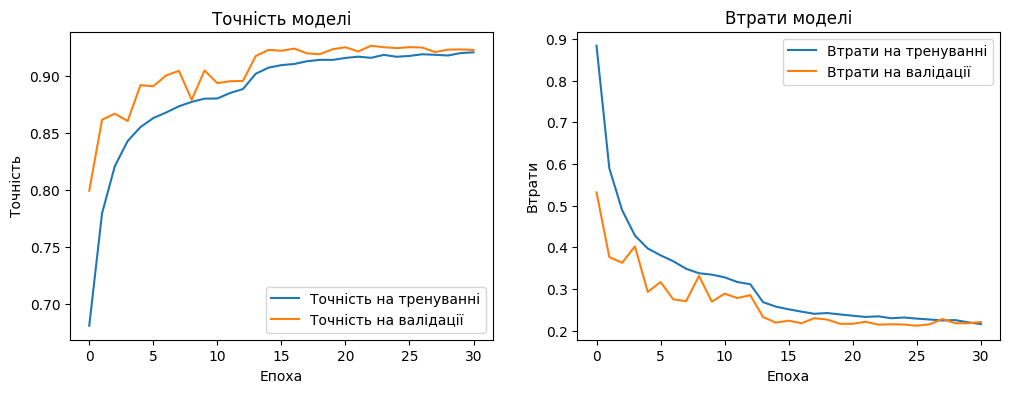

In [22]:
import matplotlib.pyplot as plt

# Графік точності
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.title('Точність моделі')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.title('Втрати моделі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.show()